In [245]:
import pickle
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.multioutput import RegressorChain
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from tqdm import tqdm
from scipy.fftpack import dct
from tsaug import TimeWarp, AddNoise, Dropout, Drift, Reverse, Pool
import statsmodels.api as sm

In [103]:
def evaluation(pred, gt, min_index):
    avg_mae = mean_absolute_error(pred[:, min_index], gt[:, min_index])
    avg_rmse = np.sqrt(mean_squared_error(pred[:, min_index], gt[:, min_index]))
    return avg_mae, avg_rmse

In [104]:
adj_mx_la = pd.read_pickle("./DCRNN/data/sensor_graph/adj_mx_la.pkl")

In [105]:
sensor_list_la = adj_mx_la[0]

In [106]:
train_LA = np.load("./DCRNN/data/METR-LA/train.npz")
test_LA = np.load("./DCRNN/data/METR-LA/test.npz")
val_LA = np.load("./DCRNN/data/METR-LA/val.npz")

In [107]:
print(train_LA["x"].shape, train_LA["y"].shape, train_LA["x_offsets"].shape, train_LA["y_offsets"].shape)
print(test_LA["x"].shape, test_LA["y"].shape, test_LA["x_offsets"].shape, test_LA["y_offsets"].shape)
print(val_LA["x"].shape, val_LA["y"].shape, val_LA["x_offsets"].shape, val_LA["y_offsets"].shape)

(23974, 12, 207, 2) (23974, 12, 207, 2) (12, 1) (12, 1)
(6850, 12, 207, 2) (6850, 12, 207, 2) (12, 1) (12, 1)
(3425, 12, 207, 2) (3425, 12, 207, 2) (12, 1) (12, 1)


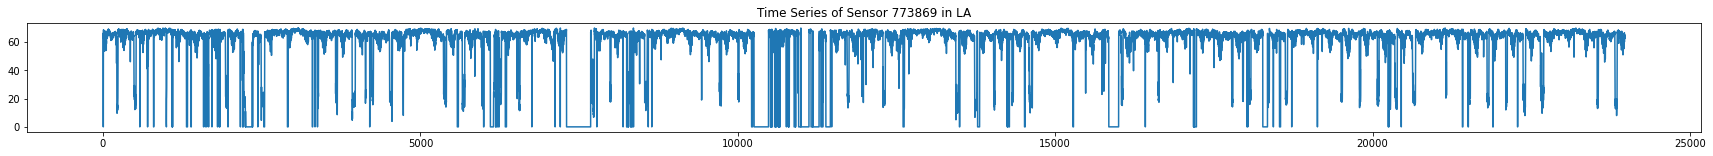

In [108]:
plt.figure(figsize=(30, 2))
plt.plot(train_LA["x"][:, :, 0, 0][:, 0])
plt.title("Time Series of Sensor " + adj_mx_la[0][0] + " in LA")
plt.show()

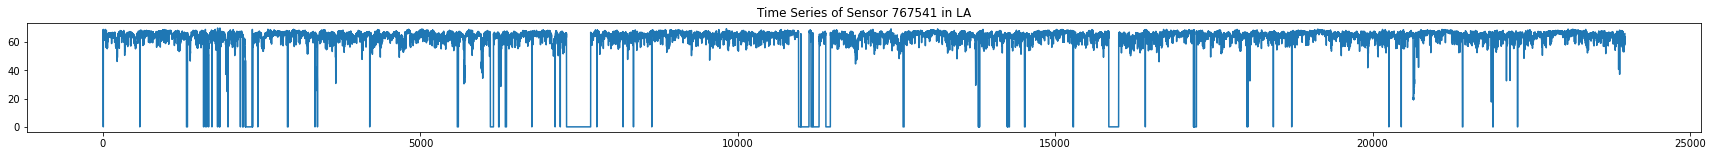

In [109]:
plt.figure(figsize=(30, 2))
plt.plot(train_LA["x"][:, :, 1, 0][:, 0])
plt.title("Time Series of Sensor " + adj_mx_la[0][1] + " in LA")
plt.show()

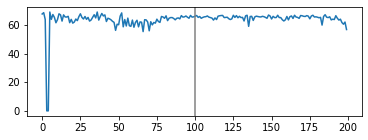

In [295]:
plt.figure(figsize=(6, 2))
timeseries_X = train_LA["x"][:, :, 1, 0][0:100, 0]
timeseries_y = train_LA["x"][:, :, 1, 0][100:200, 0]
plt.plot(np.concatenate([timeseries_X, timeseries_y]))
plt.axvline(x=100, color="grey")
plt.show()

In [296]:
my_augmenter1 = (AddNoise(scale=0.05, distr='gaussian', kind='additive'))
my_augmenter2 = (TimeWarp() * 5)
my_augmenter3 = (Reverse() @ 0.8)
my_augmenter4 = (Drift(max_drift=(0, 0.2)) @ 0.8)
my_augmenter5 = (Pool(size=3) @ 0.8)
augmenters = [my_augmenter1, my_augmenter2, my_augmenter3, my_augmenter4, my_augmenter5]
augmenter_names = ["Add Noise", "Time Warp", "Reverse", "Drift", "Pool"]

In [297]:
timeseries_X_aug1, timeseries_y_aug1 = my_augmenter1.augment(timeseries_X, timeseries_y)
timeseries_X_aug2, timeseries_y_aug2 = my_augmenter2.augment(timeseries_X, timeseries_y)
timeseries_X_aug3, timeseries_y_aug3 = my_augmenter3.augment(timeseries_X, timeseries_y)
timeseries_X_aug4, timeseries_y_aug4 = my_augmenter4.augment(timeseries_X, timeseries_y)
timeseries_X_aug5, timeseries_y_aug5 = my_augmenter5.augment(timeseries_X, timeseries_y)

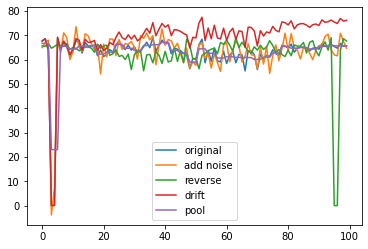

In [298]:
plt.plot(timeseries_X, label="original")
plt.plot(timeseries_X_aug1, label="add noise")
plt.plot(timeseries_X_aug3, label="reverse")
plt.plot(timeseries_X_aug4, label="drift")
plt.plot(timeseries_X_aug5, label="pool")
plt.legend()
plt.show()

In [303]:
results = []
for i in tqdm(range(len(sensor_list_la))):
    if i > 2:
        break
    print("Sensor: ", sensor_list_la[i])
    train_X = train_LA["x"][:, :, i, 0]
    train_y = train_LA["y"][:, :, i, 0]
    # val_X = val_LA["x"][:, :, i, 0]
    # val_y = val_LA["y"][:, :, i, 0]
    test_X = test_LA["x"][:, :, i, 0]
    test_y = test_LA["y"][:, :, i, 0]
    
    ### Training Model without Augmentation ###
    print("Without Augmentation")
    regr_wo = make_pipeline(StandardScaler(), MultiOutputRegressor(LinearSVR(max_iter=3000)))
    regr_wo = regr_wo.fit(train_X, train_y)
    prediction = regr_wo.predict(test_X)
    MAE_15_mins, RMSE_15_mins = evaluation(prediction, test_y, 2)
    MAE_30_mins, RMSE_30_mins = evaluation(prediction, test_y, 5)
    MAE_60_mins, RMSE_60_mins = evaluation(prediction, test_y, 11)
    print(round(MAE_15_mins, 2), round(RMSE_15_mins, 2), \
          round(MAE_30_mins, 2), round(RMSE_30_mins, 2), \
          round(MAE_60_mins, 2), round(RMSE_60_mins, 2))
    results.append([sensor_list_la[i], "Baseline", MAE_15_mins, \
                    RMSE_15_mins, MAE_30_mins, RMSE_30_mins, \
                    MAE_60_mins, RMSE_60_mins])
    ###########################################
    
    
    ### Training Model without DCT ###
    print("Discrete Cosine Transform")
    train_X_fft = dct(train_X)
    test_X_fft = dct(test_X)
    train_X_fft = np.concatenate([train_X, train_X_fft], axis=1)
    test_X_fft = np.concatenate([test_X, test_X_fft], axis=1)
    regr_wo = make_pipeline(StandardScaler(), MultiOutputRegressor(LinearSVR(max_iter=3000)))
    regr_wo = regr_wo.fit(train_X_fft, train_y)
    prediction = regr_wo.predict(test_X_fft)
    MAE_15_mins, RMSE_15_mins = evaluation(prediction, test_y, 2)
    MAE_30_mins, RMSE_30_mins = evaluation(prediction, test_y, 5)
    MAE_60_mins, RMSE_60_mins = evaluation(prediction, test_y, 11)
    print(round(MAE_15_mins, 2), round(RMSE_15_mins, 2), \
          round(MAE_30_mins, 2), round(RMSE_30_mins, 2), \
          round(MAE_60_mins, 2), round(RMSE_60_mins, 2))
    results.append([sensor_list_la[i], "DCT", MAE_15_mins, \
                    RMSE_15_mins, MAE_30_mins, RMSE_30_mins, \
                    MAE_60_mins, RMSE_60_mins])
    ###########################################
    
    ### Training Model with Augmentation ###
    for a, aug in enumerate(augmenters):
        print(augmenter_names[a])
        train_X_aug, train_y_aug = aug.augment(train_X, train_y)
        regr = make_pipeline(StandardScaler(), MultiOutputRegressor(LinearSVR(max_iter=3000)))
        regr = regr.fit(train_X_aug, train_y_aug)
        prediction_aug = regr.predict(test_X)
        MAE_15_mins, RMSE_15_mins = evaluation(prediction_aug, test_y, 2)
        MAE_30_mins, RMSE_30_mins = evaluation(prediction_aug, test_y, 5)
        MAE_60_mins, RMSE_60_mins = evaluation(prediction_aug, test_y, 11)
        print(round(MAE_15_mins, 2), round(RMSE_15_mins, 2), \
              round(MAE_30_mins, 2), round(RMSE_30_mins, 2), \
              round(MAE_60_mins, 2), round(RMSE_60_mins, 2))
        results.append([sensor_list_la[i], augmenter_names[a], MAE_15_mins, \
                        RMSE_15_mins, MAE_30_mins, RMSE_30_mins, \
                        MAE_60_mins, RMSE_60_mins])
    ########################################    

  0%|          | 0/207 [00:00<?, ?it/s]

Sensor:  773869
Without Augmentation
3.52 9.95 5.07 13.34 7.59 17.54
Discrete Cosine Transform
3.52 9.95 5.07 13.34 7.59 17.53
Add Noise
3.55 9.97 5.11 13.34 7.62 17.52
Time Warp
3.53 9.96 5.08 13.34 7.59 17.53
Reverse
7.6 17.28 8.88 19.18 11.13 22.19
Drift
3.57 9.94 5.13 13.32 7.67 17.48
Pool


  0%|          | 1/207 [00:49<2:50:39, 49.71s/it]

3.54 9.97 5.07 13.35 7.6 17.54
Sensor:  767541
Without Augmentation
2.76 8.46 3.51 10.83 4.65 13.51
Discrete Cosine Transform
2.76 8.46 3.51 10.83 4.65 13.51
Add Noise
2.78 8.49 3.53 10.83 4.66 13.51
Time Warp
2.76 8.45 3.53 10.86 4.65 13.51
Reverse
4.24 12.34 4.86 13.81 5.87 15.92
Drift
2.83 8.51 3.57 10.8 4.7 13.46
Pool


  1%|          | 2/207 [01:49<3:09:40, 55.52s/it]

2.74 8.4 3.51 10.78 4.65 13.49
Sensor:  767542
Without Augmentation
3.16 9.2 4.43 12.36 6.57 16.33
Discrete Cosine Transform
3.16 9.19 4.43 12.36 6.57 16.33
Add Noise
3.2 9.25 4.46 12.38 6.58 16.32
Time Warp
3.16 9.19 4.44 12.37 6.57 16.33
Reverse
6.7 16.41 7.64 17.96 9.04 20.17
Drift
3.2 9.22 4.47 12.35 6.61 16.26
Pool


  1%|▏         | 3/207 [02:56<3:20:10, 58.87s/it]

3.16 9.21 4.42 12.35 6.56 16.34


In [305]:
pd.DataFrame(results, columns=["Sensor_ID", "Method", "MAE_15mins", "RMSE_15mins", "MAE_30mins", \
                               "RMSE_30mins", "MAE_60mins", "RMSE_60mins"])

,Sensor_ID,Method,MAE_15mins,RMSE_15mins,MAE_30mins,RMSE_30mins,MAE_60mins,RMSE_60mins
0,773869,Baseline,3.519280,9.948725,5.073406,13.343124,7.592619,17.535299
1,773869,DCT,3.519629,9.948312,5.073107,13.341823,7.592179,17.533051
2,773869,Add Noise,3.554473,9.966886,5.109834,13.339762,7.622880,17.516131
3,773869,Time Warp,3.525039,9.964408,5.079321,13.341138,7.592931,17.531018
4,773869,Reverse,7.603322,17.281199,8.875374,19.175797,11.133809,22.189321
5,773869,Drift,3.573772,9.944956,5.133814,13.316333,7.665321,17.477554
6,773869,Pool,3.537409,9.968648,5.070753,13.349858,7.601890,17.536659
7,767541,Baseline,2.759450,8.456613,3.512883,10.834277,4.647451,13.506307
8,767541,DCT,2.758872,8.457542,3.512543,10.831045,4.648005,13.505868
9,767541,Add Noise,2.781515,8.489437,3.531155,10.830417,4.659680,13.506621
